In [1]:
from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
import pandas as pd
import pendulum
from greenflow.g import g
from tinydb import TinyDB, Query
from os import getenv
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in the 'redpanda_kafka_data' DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import greenflow.analysis as an
import qgrid

In [2]:
import greenflow.analysis as an

cutoff = "2024-07-09T21:36:18.761822+02:00"
experiments = an.get_experiments()

def interest(exp) -> bool:
  if "threshold" in exp["experiment_description"]:
    if 'Chirop' in exp["experiment_description"]:
      return True
  return False

redpanda_kafka_data = an.filter_experiments(experiments, interest, cutoff)


In [12]:
# import dill
# dill.dump_session('montcalm_threshold.db')
# dill.load_session('montcalm_threshold.db')

In [4]:
# edit = True
edit = False

if edit:
  qgrid_widget = qgrid.show_grid(redpanda_kafka_data, show_toolbar=True)


In [5]:
# qgrid_widget

In [6]:
if edit:
  redpanda_kafka_data = qgrid_widget.get_changed_df()
enriched_data = an.enrich_dataframe(redpanda_kafka_data)
if edit:
  qgrid_widget = qgrid.show_grid(enriched_data, show_toolbar=True)
  qgrid_widget

In [7]:
if edit:
  enriched_data = qgrid_widget.get_changed_df()

# The throughput gap should be negative
enriched_data = enriched_data[enriched_data["throughput_gap"] < 0]

In [8]:
# qgrid_widget = qgrid.show_grid(enriched_data, show_toolbar=True)
# qgrid_widget

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the threshold for significantly lower throughput
throughput_threshold = -20
latency_threshold = 1.5

data = enriched_data

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def stats(data, system_name):
    system_data = data[(data['exp_description'].str.contains(system_name, case=False))]

    # Display statistics for throughput gap
    print(f"Throughput Gap Statistics for {system_name}:")
    print(system_data['throughput_gap_percentage'].describe())
    print("\n")

stats(data, 'threshold')

Throughput Gap Statistics for threshold:
count    495.000000
mean     -28.537717
std       30.418573
min      -95.313198
25%      -52.272959
50%      -13.950249
75%       -5.158281
max       -0.400000
Name: throughput_gap_percentage, dtype: float64




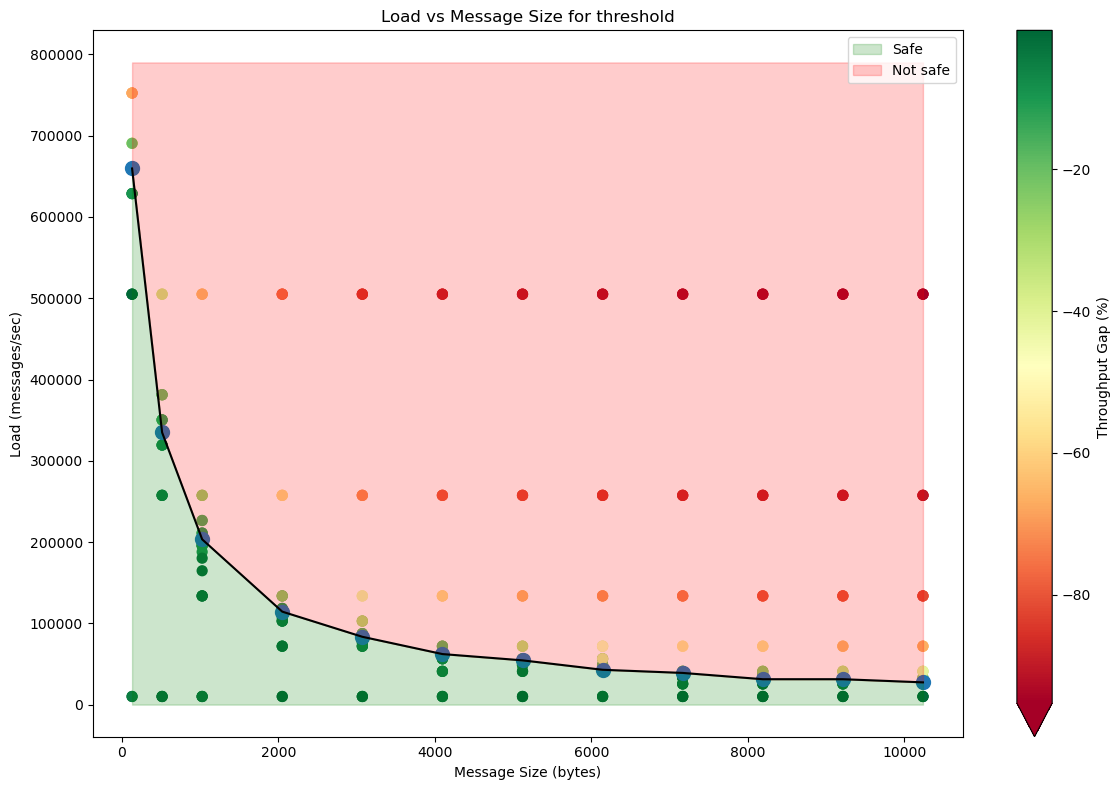

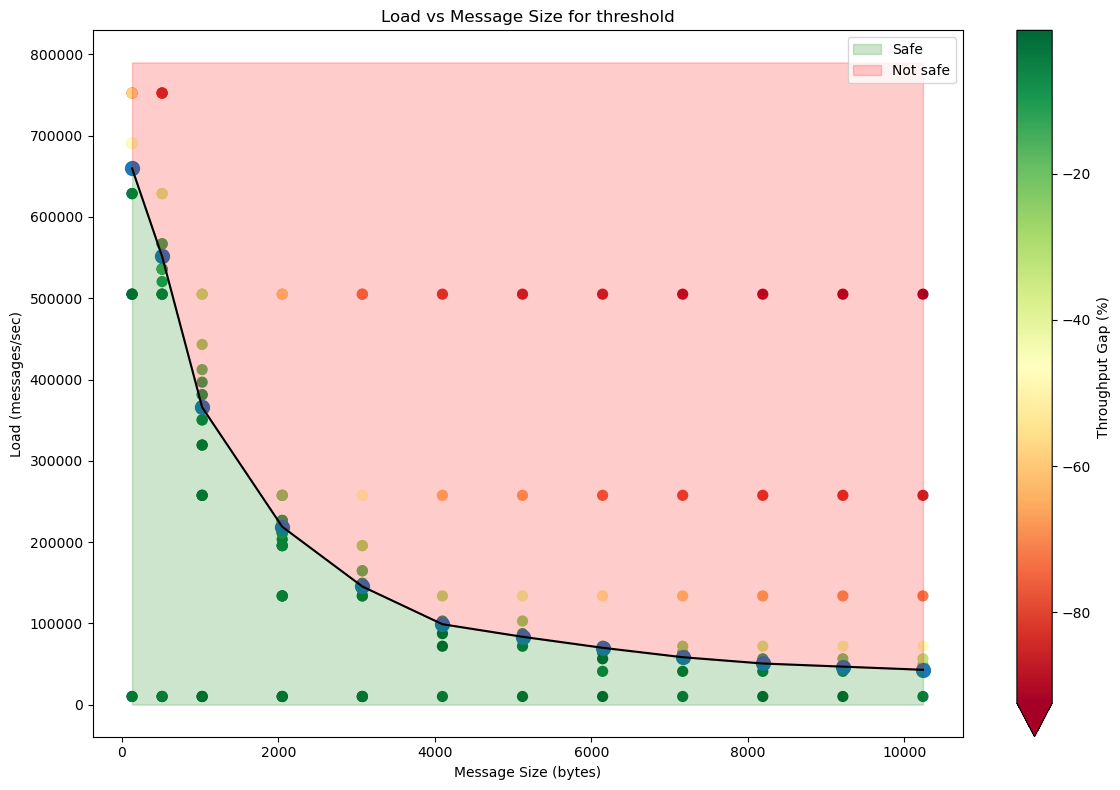

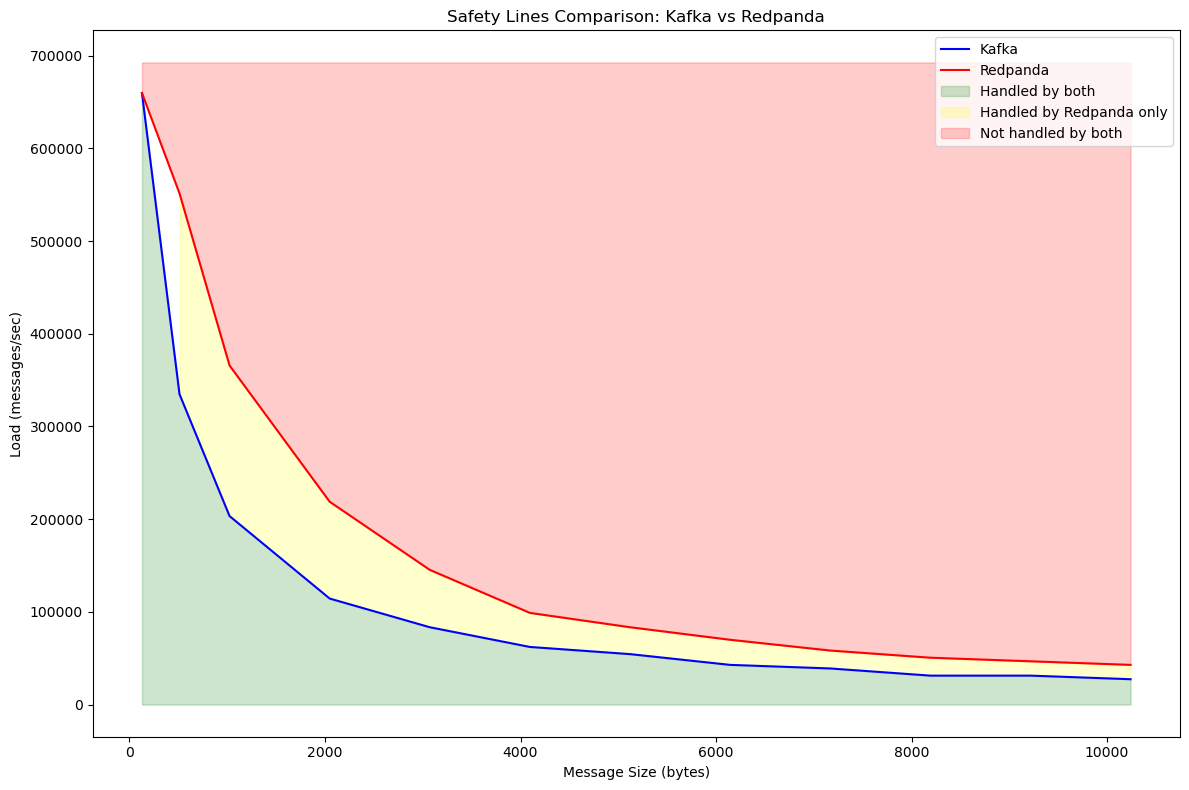

In [11]:
# Function to create the graph for a specific system
def create_graph(data, system_name):
    # Filter data for the specific system
    system_data = data[data["exp_description"].str.contains(system_name, case=False)]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    cmap = plt.cm.RdYlGn

    # Create scatter plot for all points except the last point for each message size
    scatter = ax.scatter(
        system_data["messageSize"][:-1],
        system_data["load"][:-1],
        c=system_data["throughput_gap_percentage"][:-1],
        cmap=cmap,
        s=50,
    )

    # Create scatter plot for the last point of each message size with a different marker style
    last_points = system_data.groupby("messageSize").first()
    ax.scatter(
        last_points.index,
        last_points["load"],
        s=100,
        marker="o",
        linewidths=1,
    )

    # Sort the last points by messageSize
    last_points = last_points.sort_index()

    # Connect the last points with a line
    ax.plot(last_points.index, last_points["load"], linestyle="-", color="black")

    # Fill the area below the line as "Safe"
    ax.fill_between(last_points.index, last_points["load"], color="green", alpha=0.2, label="Safe")

    # Fill the area above the line as "Not safe"
    ax.fill_between(last_points.index, last_points["load"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not safe")

    # Add color bar
    plt.colorbar(scatter, ax=ax, label="Throughput Gap (%)", extend="min")

    ax.set_title(f"Load vs Message Size for {system_name}")
    ax.set_xlabel("Message Size (bytes)")
    ax.set_ylabel("Load (messages/sec)")

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()

    return last_points


# Create graphs for Montcalm and Neowise
kafka_last_points = create_graph(data[data["exp_name"] == "ingest-kafka"], "threshold")
redpanda_last_points = create_graph(data[data["exp_name"] == "ingest-redpanda"], "threshold")

# Create a new figure for comparing the safety lines
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the safety lines for Kafka and Redpanda
ax.plot(kafka_last_points.index, kafka_last_points["load"], linestyle="-", color="blue", label="Kafka")
ax.plot(redpanda_last_points.index, redpanda_last_points["load"], linestyle="-", color="red", label="Redpanda")

# Fill the region that can be handled by both Kafka and Redpanda
ax.fill_between(kafka_last_points.index, kafka_last_points["load"], color="green", alpha=0.2, label="Handled by both")

# Fill the region that can be handled by Redpanda but not Kafka
ax.fill_between(kafka_last_points.index, kafka_last_points["load"], redpanda_last_points["load"], where=(redpanda_last_points["load"] > kafka_last_points["load"]), color="yellow", alpha=0.2, label="Handled by Redpanda only")

# Fill the region that cannot be handled by both
ax.fill_between(redpanda_last_points.index, redpanda_last_points["load"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not handled by both")

ax.set_title("Safety Lines Comparison: Kafka vs Redpanda")
ax.set_xlabel("Message Size (bytes)")
ax.set_ylabel("Load (messages/sec)")

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


# Get unique message sizes
message_sizes = data["messageSize"].unique()
message_sizes.sort()

# Create a figure with subplots for each message size
fig, axs = plt.subplots(len(message_sizes), 3, figsize=(18, 6 * len(message_sizes)))

for j, message_size in enumerate(message_sizes):
    # Filter data by message size
    size_data = data[data["messageSize"] == message_size]

    # Plot load vs observed throughput
    for i, exp_name in enumerate(["ingest-kafka", "ingest-redpanda"]):
        data = size_data[size_data["exp_name"] == exp_name]
        sns.scatterplot(
            x="load", y="observed_throughput", data=data, s=80, ax=axs[j, 0]
        )

        # Highlight instances with significantly lower throughput
        low_throughput = data[data["throughput_gap_percentage"] < throughput_threshold]
        axs[j, 0].scatter(
            x=low_throughput["load"],
            y=low_throughput["observed_throughput"],
            color="red",
            marker="x",
            s=100,
            label=f"Low Throughput (<{throughput_threshold}%)",
        )

    axs[j, 0].set_title(
        f"Load vs Observed Throughput\nMessage Size: {message_size} bytes"
    )
    axs[j, 0].set_xlabel("Load Intensity (messages/sec)")
    axs[j, 0].set_ylabel("Observed Throughput (messages/sec)")
    axs[j, 0].legend()

    # Filter out instances with significantly lower throughput or higher latency for each experiment and message size
    filtered_data = {}
    for exp_name in ["ingest-kafka", "ingest-redpanda"]:
        filtered_data[exp_name] = size_data[size_data["exp_name"] == exp_name]
    # for exp_name in ['ingest-kafka', 'ingest-redpanda']:
    #     filtered_data[exp_name] = size_data[
    #         (size_data['exp_name'] == exp_name) &
    #         (size_data['throughput_gap_percentage'] >= throughput_threshold) &
    #         (size_data['latency_p99'] <= latency_threshold)
    #     ]

    # Plot observed throughput vs latency (filtered data)
    for i, exp_name in enumerate(["ingest-kafka", "ingest-redpanda"]):
        data = filtered_data[exp_name]
        sns.scatterplot(
            x="observed_throughput",
            y="latency_p99",
            data=data,
            s=80,
            ax=axs[j, 1],
            label=exp_name,
        )

    axs[j, 1].set_title(
        f"Observed Throughput vs Latency (p99)\nMessage Size: {message_size} bytes"
    )
    axs[j, 1].set_xlabel("Observed Throughput (messages/sec)")
    axs[j, 1].set_ylabel("Latency (p99) (seconds)")
    axs[j, 1].legend()

    # Plot observed throughput vs average power (filtered data)
    for i, exp_name in enumerate(["ingest-kafka", "ingest-redpanda"]):
        data = filtered_data[exp_name]
        sns.regplot(
            x="observed_throughput",
            y="average_power",
            data=data,
            scatter_kws={"s": 80},
            line_kws={"label": exp_name},
            ax=axs[j, 2],
        )

    axs[j, 2].set_title(
        f"Observed Throughput vs Average Power\nMessage Size: {message_size} bytes"
    )
    axs[j, 2].set_xlabel("Observed Throughput (messages/sec)")
    axs[j, 2].set_ylabel("Average Power (watts)")
    axs[j, 2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()